# Testing methods for extracting CO2 fertilisation effect from GPP datasets


In [1]:
%matplotlib inline

import os
import sys
import pickle
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import scipy.stats
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
from scipy.signal import detrend
from scipy.stats import theilslopes, kendalltau

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression

# sys.path.append('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/src')

## Analysis Parameters

In [2]:
# k = 'Alice Tableland'
# k = 'Western Mallee'
# k='Daintree-Bloomfield'
k='Warre'

# NDVI data
# ds_path = '/g/data/ub8/au/AusEFlux/v2/annual/AnnualSum/GPP/'
ds_path = f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/DIFFUSE_GPP_1km_monthly_2003_2021.nc'

# soil NDVI
ndvi_min_path =f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/ndvi_of_baresoil_5km.nc'

#ibra subregions
ecoregions_file = f'/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'

#climate data
covar_file = f'/g/data/os22/chad_tmp/Aus_phenology/data/covars.nc'


## Interactively plot IBRA regions

Hover over the regions to see its name

In [3]:
# gdf = gpd.read_file(ecoregions_file)
# gdf.explore(column='SUB_NAME_7',
#             tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#             attr = 'Esri',
#             name = 'Esri Satellite',
#             control = True,
#             legend=False
#            )

## Open data

In [4]:
gdf = gpd.read_file(ecoregions_file)

ds = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326')['DIFFUSE_GPP']
ds = ds.rename('GPP')

# files = [f'{ds_path}/{i}' for i in os.listdir(ds_path) if i.endswith(".nc")]
# files.sort()
# ds = xr.open_mfdataset(files).sel(time=slice('2003','2022'))['GPP_median']
# ds = assign_crs(ds, crs='EPSG:4326')
# ds.attrs['nodata'] = np.nan
# ds = ds.rename('GPP').compute()

covariables =  xr.open_dataset(covar_file)
covariables = covariables.drop_vars('wcf')

## Clip to a region

In [5]:
gdf = gdf[gdf['SUB_NAME_7']==k]

In [6]:
#clip to ecoregion
geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)
ds = ds.odc.mask(poly=geom)
ds = ds.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')
ds = ds * ds.time.dt.daysinmonth #For DIFFUSE convert to monthly flux from daily flux 
ds = ds.groupby('time.year').sum() # annual sum

covariables = covariables.odc.mask(poly=geom)
covariables = covariables.dropna(dim='longitude', how='all').dropna(dim='latitude', how='all')

# #summarise into 1d timeseries
ds = ds.mean(['latitude', 'longitude'])
covariables = covariables.mean(['latitude', 'longitude'])

## Summarise climate and CO2 data

In [7]:
co2 = covariables['co2'].groupby('time.year').mean()
rain = covariables['rain'].groupby('time.year').sum()
covariables = covariables.drop_vars(['rain', 'co2']).groupby('time.year').mean()

covariables = xr.merge([co2.to_dataset(), rain.to_dataset(), covariables]).sel(year=slice('2003', '2021'))

## Testing implementing GPP residual method

Following [Zhan et al 2024](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2023JG007910)

Steps:
1. Detrend NDVI/GPP, add back median value.
2. Detrend climate variables (T, VPD, rainf, SW), add back median value.
3. Train model: NDVI-detrend = f(climate detrend)
4. Predict NDVI with original climate data using model
5. NDVI residual = Actual NDVI - predicted NDVI
6. Beta = linear trend of NDVI residual vs CO2.

### Steps 1 and 2

In [8]:
df = ds.drop_vars('spatial_ref').to_dataframe(name='GPP')#.reset_index()
# df.index = df.index.year
# df.index.name = 'year'
df_covars = covariables.drop_vars('spatial_ref').to_dataframe()
df = pd.merge(df, df_covars,  on='year')

In [9]:
for v in ['GPP', 'rain', 'srad', 'tavg', 'vpd']:
    df[f'{v}_detrend'] = detrend(df[v])
    df[f'{v}_detrend'] = df[f'{v}_detrend'] + df[v].median()

df.head(3)

,GPP,co2,rain,srad,tavg,vpd,GPP_detrend,rain_detrend,srad_detrend,tavg_detrend,vpd_detrend
year,,,,,,,,,,,
2003,337.383327,371.994110,1106.006226,16.261774,16.017534,6.973714,352.769829,1152.068115,16.226957,16.133512,7.126357
2004,358.139912,374.030792,934.832397,16.505545,15.721725,7.121325,371.894599,979.935852,16.464203,15.822343,7.251122
2005,358.722686,375.911469,1163.908325,15.875427,15.331692,6.355411,370.845558,1208.053223,15.827562,15.416949,6.462363


### Step 3

In [10]:
#fit a model
x = df[['rain_detrend', 'srad_detrend', 'tavg_detrend', 'vpd_detrend']] #detrended data
xx = df[['rain', 'srad', 'tavg', 'vpd']]
y = df['GPP_detrend']

#fit a RF model using detrended values
rf = RandomForestRegressor(n_estimators=100).fit(x, y)

### Step 4

In [11]:
## predict using original climate data (add suffix to trick scikit learn)
df['GPP_predict'] = rf.predict(xx.add_suffix('_detrend'))

### Step 5

In [12]:
df['GPP_residual'] = df['GPP'] - df['GPP_predict']
df['GPP_residual_percent'] = df['GPP_residual']/df['GPP'][0:5].mean()

### Step 6

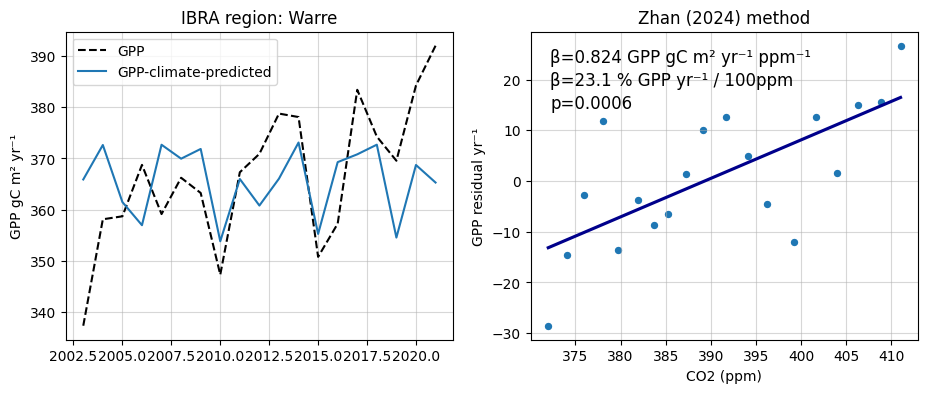

In [22]:
#find robust regression slope
beta  = theilslopes(y=df['GPP_residual'], x=df['co2']).slope
beta_relative = theilslopes(y=df['GPP_residual_percent'], x=df['co2']).slope * 100 * 100
pvalue = kendalltau(y=df['GPP_residual'], x=df['co2']).pvalue

# beta  = linregress(y=df['NDVI_residual'], x=df['co2']).slope
# beta_relative = linregress(y=df['NDVI_residual_percent'], x=df['co2']).slope * 100 * 100

# beta_relative = 

fig,ax = plt.subplots(1,2, figsize=(11,4))
df['GPP'].plot(ax=ax[0], label='GPP', linestyle='dashed', color='k')
df['GPP_predict'].plot(ax=ax[0], label='GPP-climate-predicted')
ax[0].set_ylabel('GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹')
ax[0].set_title('IBRA region: '+k)
ax[0].grid(alpha=0.5)
ax[0].set_xlabel(None)
ax[0].legend()

sb.scatterplot(data=df, x='co2',y='GPP_residual', s=40, lw=1,ax=ax[1])
sb.regplot(data=df, x='co2',y='GPP_residual', scatter=False, color='darkblue', ax=ax[1], ci=None, robust=False)
ax[1].set_ylabel('GPP residual yr⁻¹')
ax[1].set_xlabel('CO2 (ppm)')
# ax[1].set_ylim(-2,2)
ax[1].grid(alpha=0.5)
ax[1].set_title('Zhan (2024) method')
ax[1].text(.05, .90, '\u03B2={:.3f} GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹ ppm⁻¹'.format(beta) ,
            transform=ax[1].transAxes, fontsize=12);
ax[1].text(.05, .825, '\u03B2={:.1f} % GPP / 100ppm'.format(beta_relative) ,
            transform=ax[1].transAxes, fontsize=12);
ax[1].text(.05, .75, 'p={:.4f}'.format(pvalue) ,
            transform=ax[1].transAxes, fontsize=12);

## Test experiments holding CO2 constant

Residual between prediction when all variables kept original, and where CO2 is kept constant.

1. Model GPP/NDVI using CO2, SRAD, VPD, rain, Tavg
2. Model GPP/NDVI with CO2 set at average of first 3 years.
3. Find residual between GPP/NDVI-predicted and GPP/NDVI-CO2-constant
4. Plot residual GPP/NDVI against CO2 and determine beta

### Modelling

In [20]:
# fit a model on observed data
x = df[['rain', 'srad', 'tavg', 'vpd', 'co2']] # original data
y = df['GPP']

lr = PLSRegression(n_components=2).fit(x, y)
prediction = lr.predict(x)

# now fit a model with CO2 held constant
constant_co2 = x['co2'].iloc[0:3].mean() #average of first 3 years
xx = x.drop('co2', axis=1)
xx['co2'] = constant_co2

lrr = PLSRegression(n_components=2).fit(xx, y)
pred_co2_constant = lrr.predict(xx)

# determine residual between predicted with and without co2 held constant
df['GPP_residual_co2constant'] =  prediction - pred_co2_constant

df['GPP_residual_co2constant_percent'] = df['GPP_residual_co2constant']/np.mean(prediction[0:5]) #

### Plot

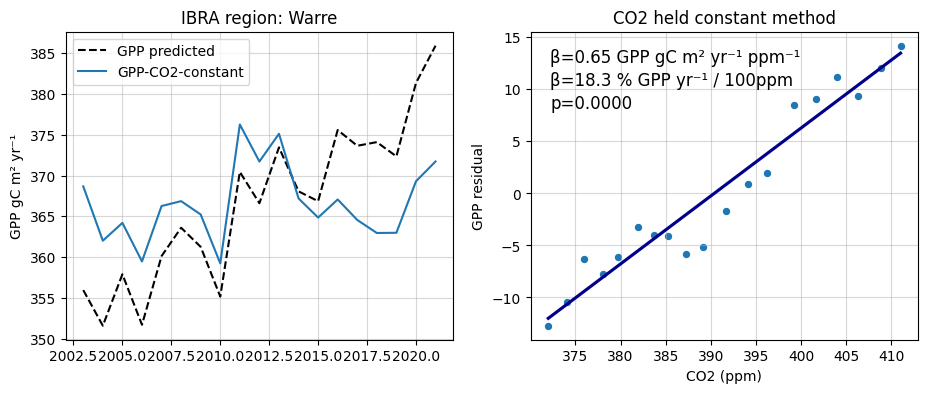

In [21]:
#find robust regression slope
regress  = theilslopes(y=df['GPP_residual_co2constant'], x=df['co2'])
beta = regress.slope 

beta_relative = theilslopes(y=df['GPP_residual_co2constant_percent'], x=df['co2']).slope * 100 * 100
pvalue = kendalltau(y=df['GPP_residual_co2constant'], x=df['co2']).pvalue

fig,ax = plt.subplots(1,2, figsize=(11,4))
ax[0].plot(df.index, prediction, label='GPP predicted', linestyle='dashed', color='k')
ax[0].plot(df.index, pred_co2_constant, label='GPP-CO2-constant')
# ax[0].plot(df.index, df['NDVI'].values, label='iNDVI-Observed')

ax[0].set_ylabel('GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹')
ax[0].set_title('IBRA region: '+k)
ax[0].grid(alpha=0.5)
ax[0].set_xlabel(None)
ax[0].legend()

sb.scatterplot(data=df, x='co2',y='GPP_residual_co2constant', s=40, lw=1,ax=ax[1])
sb.regplot(data=df, x='co2',y='GPP_residual_co2constant', scatter=False, color='darkblue', ax=ax[1], ci=None, robust=True)
ax[1].set_ylabel('GPP residual')
ax[1].set_xlabel('CO2 (ppm)')
# ax[1].set_ylim(-300,300)
ax[1].set_title('CO2 held constant method')
ax[1].grid(alpha=0.5)
ax[1].text(.05, .90, '\u03B2={:.2f} GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹ ppm⁻¹'.format(beta),
            transform=ax[1].transAxes, fontsize=12);
ax[1].text(.05, .825, '\u03B2={:.1f} % GPP yr⁻¹ / 100ppm'.format(beta_relative) ,
            transform=ax[1].transAxes, fontsize=12);
ax[1].text(.05, .75, 'p={:.4f}'.format(pvalue) ,
            transform=ax[1].transAxes, fontsize=12);

##

In [ ]:
# k = 'Eastern Darling Downs rainfed crop' # Claraville Plains Eastern Darling Downs rainfed crop Geraldton Hills rainfed crop

# ds = eco_regions_phenometrics[k].to_xarray().expand_dims(latitude=[-33.0],longitude=[135.0])

In [ ]:
# def calculate_beta(ds):
#     # count number of seasons
#     # and how many years was this over?
#     n_seasons = len(ds.index)
    
#     a = ds.POS_year.isel(index=0).values.item()
#     b = ds.POS_year.isel(index=-1).values.item()
    
#     if np.isnan(a):
#         n_years=39
#     else:
#         n_years = len([i for i in range(int(a),int(b)+1)])
    
#     #first check if its nodata and do a quick mean
#     # if ds.vPOS.isel(index=0).values.item() == -99.0:
#     if np.isnan(ds.vPOS.isel(index=0).values.item()):
#         dd = ds.mean('index')
        
#     else: 
#         #calculate circular statistics for seasonal timings
#         circ_stats = []
#         for var in ['SOS', 'POS', 'EOS', 'TOS']:
            
#             data = pd.DataFrame({
#                 "year": ds[f'{var}_year'].squeeze().values,
#                 "day_of_year": ds[var].squeeze().values
#             })
        
#             # Number of days in a year (adjusting for leap years)
#             data['days_in_year'] = data['year'].apply(lambda y: 366 if y % 4 == 0 and (y % 100 != 0 or y % 400 == 0) else 365)
            
#             # Convert day-of-year to circular coordinates doy / 365 * 2 * np.pi
#             data['theta'] = data['day_of_year']*((2*np.pi)/data['days_in_year'])
#             data['theta_unwrap'] = np.unwrap(data['theta'])
            
#             # Calculate circular mean, convert back to DOY
#             circular_mean = circmean(data['theta'], nan_policy='omit')
#             circular_std = circstd(data['theta'], nan_policy='omit')
#             circular_mean_doy = circular_mean / (2 * np.pi) * 365
#             # circular_std_doy = circular_std / (2 * np.pi) * 365
        
#             df = pd.DataFrame({
#                 f'{var}': [circular_mean_doy],
#                 # f'{var}_std': [circular_std_doy],
#                 })
        
#             circ_stats.append(df)

#         # For the other variables use Kirill's much much faster quantile function (median stats)
#         dd_circ = pd.concat(circ_stats, axis=1).to_xarray().squeeze().expand_dims(latitude=ds.latitude,longitude=ds.longitude).drop_vars('index')
#         ds = ds.transpose('index', 'latitude', 'longitude')
#         other_vars=['vTOS','vSOS','vPOS','vEOS','AOS','LOS','IOS','IOC','LOC','ROG','ROS']
#         dd_median = xr_quantile(ds[other_vars], quantiles=[0.5], nodata=np.nan)
#         dd_median = dd_median.sel(quantile=0.5).drop_vars('quantile')
        
#         dd = xr.merge([dd_median, dd_circ]).astype('float32')

#     # add new variable with number of seasons
#     dd['n_seasons'] = n_seasons
#     dd['n_seasons'] = dd['n_seasons'].expand_dims(
#         latitude=dd.latitude,
#         longitude=dd.longitude
#     )
    
#     dd['n_years'] = n_years
#     dd['n_years'] = dd['n_years'].expand_dims(
#         latitude=dd.latitude,
#         longitude=dd.longitude
#     )
#     return dd


In [ ]:
# circular_mean_and_median(ds)